In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 12


In [1]:
from GCR import GCRQuery

In [2]:
import GCRCatalogs

In [3]:


# using protoDC2_test here to bypass md5 check.
# using buzzard_test here because full buzzard is very big!

catalogs = ('protoDC2_test', 'buzzard_test')
gc_all = dict(zip(catalogs, (GCRCatalogs.load_catalog(c) for c in catalogs)))



/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


In [15]:
gc_all["protoDC2_test"].ge

In [9]:
class ConditionalLuminosityFunction(object):
    
    def __init__(self, band='r', magnitude_bins=None, mass_bins=None, z_bins=None, **kwargs):
        
        possible_Mag_fields = ('Mag_true_{}_lsst_z0', 
                               'Mag_true_{}_lsst_z01', 
                               'Mag_true_{}_des_z0', 
                               'Mag_true_{}_des_z01',
                               'Mag_true_{}_sdss_z0',
                               'Mag_true_{}_sdss_z01',
                              )
        
        self.possible_Mag_fields = [f.format(band) for f in possible_Mag_fields]
        self.band = band
        
        self.magnitude_bins   = magnitude_bins or np.linspace(-25, -18, 29)
        self.mass_bins        = mass_bins or np.logspace(12, 15, 5)
        self.z_bins           = z_bins or np.linspace(0, 0.5, 3)
        
        self.n_magnitude_bins = len(self.magnitude_bins) - 1
        self.n_mass_bins      = len(self.mass_bins) - 1
        self.n_z_bins         = len(self.z_bins) - 1

        self.dmag = self.magnitude_bins[1:] - self.magnitude_bins[:-1]
        self.mag_center = (self.magnitude_bins[1:] + self.magnitude_bins[:-1])*0.5
        
        self._other_kwargs = kwargs
        
        
    def prepare_galaxy_catalog(self, gc):
        
        quantities_needed = {'redshift_true', 'is_central', 'halo_mass'}

        if gc.has_quantities(['truth/RHALO', 'truth/R200']):
            gc.add_quantity_modifier('r_host', 'truth/RHALO', overwrite=True)
            gc.add_quantity_modifier('r_vir', 'truth/R200', overwrite=True)
            quantities_needed.add('r_host')
            quantities_needed.add('r_vir')

        try:
            absolute_magnitude_field = gc.first_available(*self.possible_Mag_fields)
        except ValueError:
            return

        quantities_needed.add(absolute_magnitude_field)
        if not gc.has_quantities(quantities_needed):
            return

        return absolute_magnitude_field, quantities_needed
        
        
    def run_validation_test(self, galaxy_catalog, catalog_name, base_output_dir=None):
        
        prepared = self.prepare_galaxy_catalog(galaxy_catalog)
        if prepared is None:
            TestResult(skipped=True)

        absolute_magnitude_field, quantities_needed = prepared
        colnames = [absolute_magnitude_field, 'halo_mass', 'redshift_true']
        bins = (self.magnitude_bins, self.mass_bins, self.z_bins)
        hist_cen = np.zeros((self.n_magnitude_bins, self.n_mass_bins, self.n_z_bins))
        hist_sat = np.zeros_like(hist_cen)

        cen_query = GCRQuery('is_central')
        sat_query = ~cen_query
        if 'r_host' in quantities_needed and 'r_vir' in quantities_needed:
            sat_query &= GCRQuery('r_host < r_vir')

        for data in galaxy_catalog.get_quantities(quantities_needed, return_iterator=True):
            cen_mask = cen_query.mask(data)
            sat_mask = sat_query.mask(data)
            data = np.stack((data[k] for k in colnames)).T
            hist_cen += np.histogramdd(data[cen_mask], bins)[0]
            hist_sat += np.histogramdd(data[sat_mask], bins)[0]

        del data, cen_mask, sat_mask

        halo_counts = hist_cen.sum(axis=0)
        clf = dict()
        clf['sat'] = hist_sat / halo_counts
        clf['cen'] = hist_cen / halo_counts
        clf['tot'] = clf['sat'] + clf['cen']

        return clf
        
        
    def make_plot(self, clf, name):
        fig, ax = plt.subplots(self.n_mass_bins, self.n_z_bins, sharex=True, sharey=True, figsize=(12,10), dpi=100)

        for i in range(self.n_z_bins):
            for j in range(self.n_mass_bins):
                ax_this = ax[j,i]
                for k, ls in zip(('total', 'satellites', 'centrals'), ('-', ':', '--')):
                    ax_this.semilogy(self.mag_center, clf[k[:3]][:,j,i]/self.dmag, label=k, ls=ls)
                ax_this.set_ylim(0.05, 50)
                bins = self.mass_bins[j], self.mass_bins[j+1], self.z_bins[i], self.z_bins[i+1]
                ax_this.text(-25, 10, '${:.1E}\\leq M <{:.1E}$\n${:g}\\leq z<{:g}$'.format(*bins))

        ax_this.legend(loc='lower right', frameon=False, fontsize='medium')

        ax = fig.add_subplot(111, frameon=False)
        ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
        ax.grid(False)
        ax.set_ylabel(r'$\phi(M_{{{}}}\,|\,M_{{\rm vir}},z)\quad[{{\rm Mag}}^{{-1}}]$'.format(self.band))
        ax.set_xlabel(r'$M_{{{}}}\quad[{{\rm Mag}}]$'.format(self.band))
        ax.set_title(name)

        fig.tight_layout()
        display(fig)
        plt.close(fig)


In [10]:
clf_test = ConditionalLuminosityFunction()

In [11]:
clf_all = dict()
for label, gc_this in gc_all.items():
    clf_all[label] = clf_test.run_validation_test(gc_this, label)

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:72: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: divide by zero encountered in true_divide
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in true_divide
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in true_divide


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


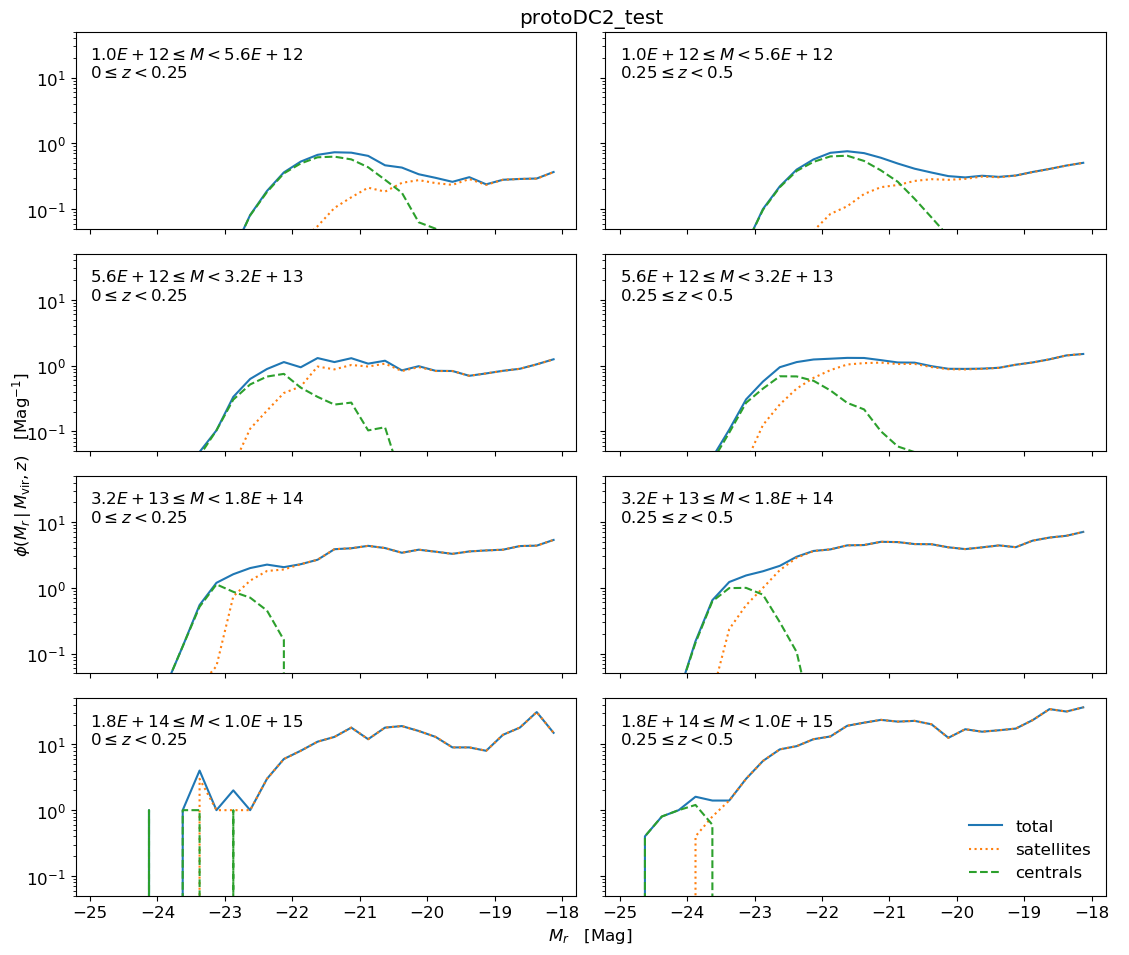

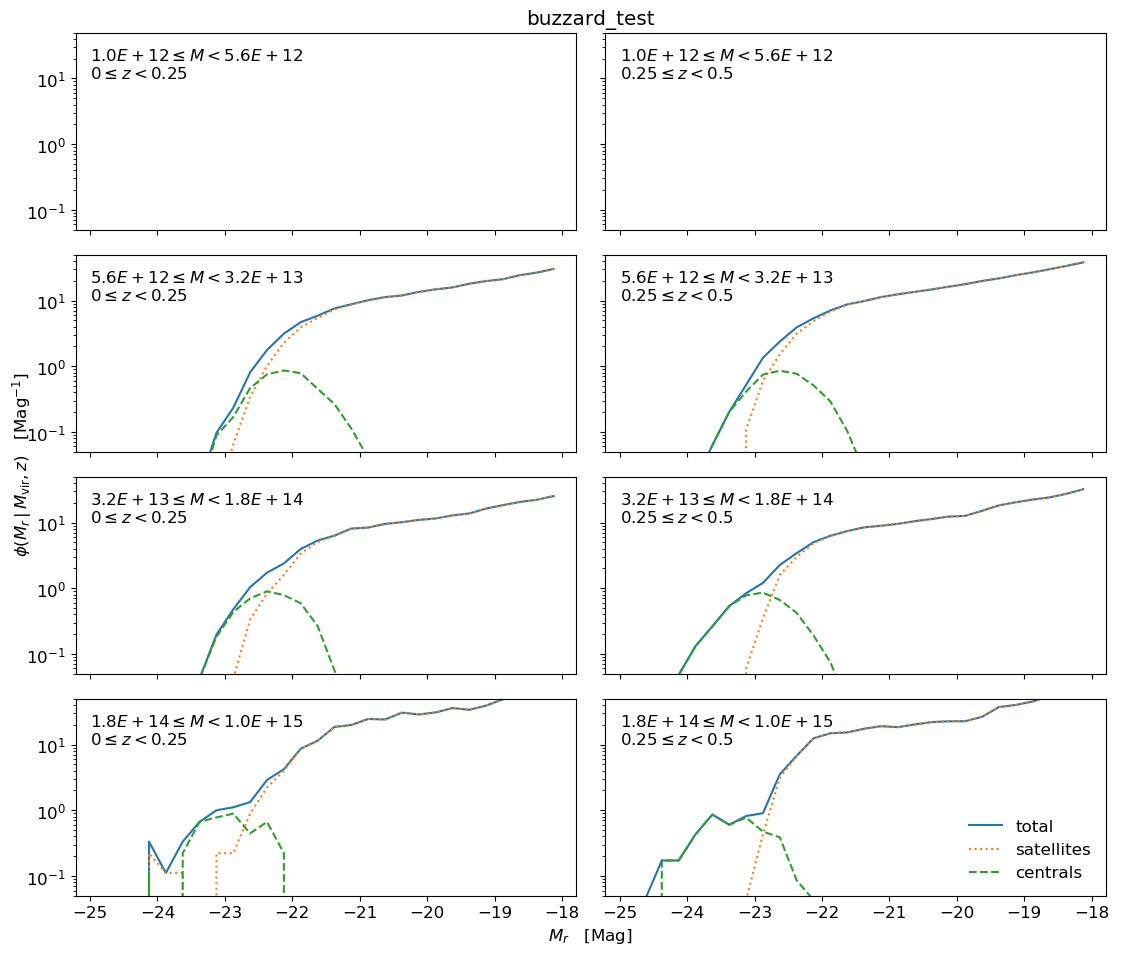

In [12]:
for label, clf_this in clf_all.items():
    clf_test.make_plot(clf_this, label)